In [42]:
import matplotlib.pyplot as plt
from matplotlib import colors
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as sts

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, auc, confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import class_weight
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier



from scipy import stats
from prettytable import PrettyTable

In [3]:
data = pd.read_csv('data.csv')

Function for scores and ROC curve with corss-validation

In [4]:
def scores(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    return accuracy, precision, recall, f1

In [5]:

def perso_roc(test, X, y):
    y_pred_proba_cv = cross_val_predict(test, X, y, cv=5, method='predict_proba')

    # Compute the ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(np.unique(y))
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve((y == i).astype(int), y_pred_proba_cv[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot the ROC curves for each class
    plt.figure()
    colors = plt.cm.get_cmap('tab10', n_classes)
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], color=colors(i), label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - OvR')
    plt.legend(loc='lower right')

### Feature Selection with Correlation based method

In [6]:
corr_matrix = data.corr()

In [7]:
correlation_with_target = corr_matrix['metric_item_label'].abs().sort_values(ascending=False)
selected_features_corr = correlation_with_target[:15].index.tolist()

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

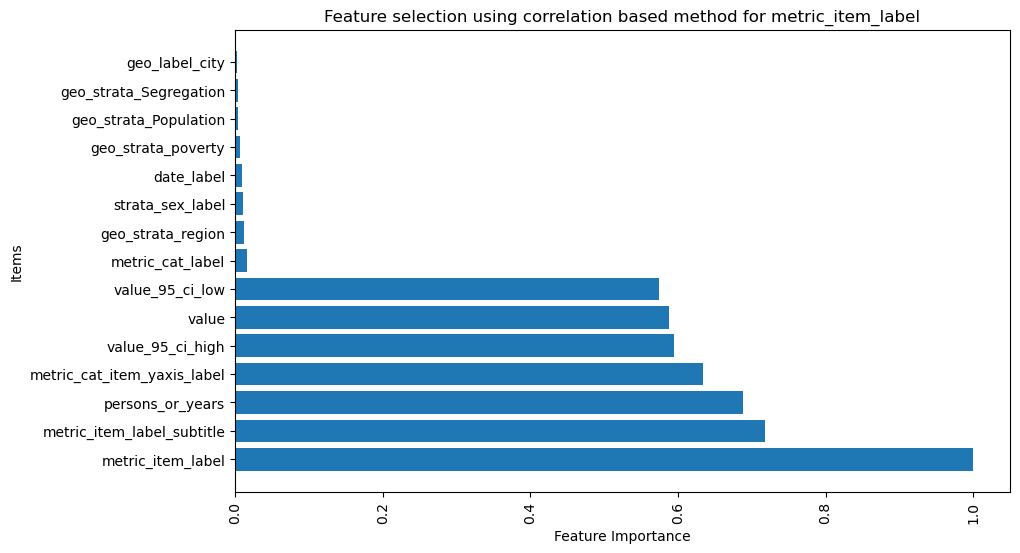

In [8]:
plt.figure(figsize=(10, 6))
plt.barh(selected_features_corr, correlation_with_target[selected_features_corr])
plt.xlabel('Feature Importance')
plt.ylabel('Items')
plt.title('Feature selection using correlation based method for metric_item_label')
plt.xticks(rotation=90)

Selected the 25 best features

In [9]:
selected_features_corr = data[selected_features_corr].columns.tolist()

### Random Forest Model

In [10]:
X = data[selected_features_corr]
y = data['metric_item_label']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Changing Hyperparamters

In [12]:
RF = RandomForestClassifier(n_estimators=3, max_depth=3, max_samples=10, class_weight='balanced')
RF.fit(X_train, y_train)
y_pred_RF = RF.predict(X_test)

In [13]:
y_pred_proba_rf = RF.predict_proba(X_test) 
auc_RF = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr')

Random Forest AUC: 0.7935883892306733


In [14]:
accuracy_RF, precision_RF, recall_RF, f1_RF = scores(y_test, y_pred_RF)

print(f"Accuracy: {accuracy_RF}")
print(f"Precision: {precision_RF}")
print(f"Recall: {recall_RF}")
print(f"F1 Score: {f1_RF}")

Accuracy: 0.7313264346190028
Precision: 0.6891714729820948
Recall: 0.7313264346190028
F1 Score: 0.703135548159631


Text(0.5, 1.0, 'ROC: Correlation Based - Random Forest')

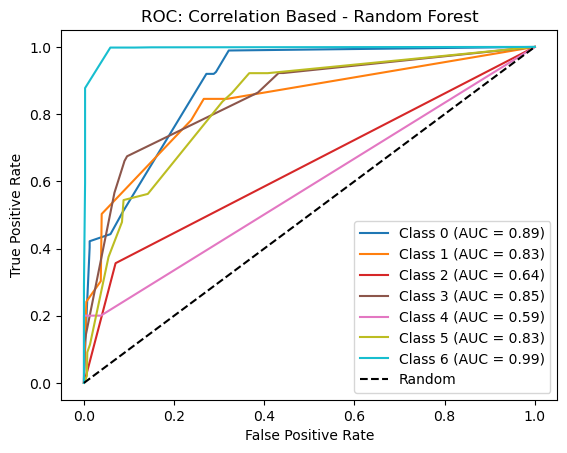

In [15]:
perso_roc(RF, X, y)
plt.title('ROC: Correlation Based - Random Forest')

### Logistic Regression Model

In [16]:
LogReg = LogisticRegression(multi_class='multinomial', solver='saga', max_iter=30, penalty='l2', class_weight='balanced', C=100)

In [17]:
LogReg.fit(X_train, y_train)
y_pred_LogReg = LogReg.predict(X_test)

In [32]:
y_pred_proba_LR = LogReg.predict_proba(X_test) 
auc_LogReg = roc_auc_score(y_test, y_pred_proba_LR, multi_class='ovr')


Logistic Regression AUC: 0.8986169140389263


In [19]:
accuracy_LogReg, precision_LogReg, recall_LogReg, f1_LogReg = scores(y_test, y_pred_LogReg)

print(f"Accuracy: {accuracy_LogReg}")
print(f"Precision: {precision_LogReg}")
print(f"Recall: {recall_LogReg}")
print(f"F1 Score: {f1_LogReg}")

Accuracy: 0.6190028222013171
Precision: 0.7840563486713713
Recall: 0.6190028222013171
F1 Score: 0.6598645127807881


Text(0.5, 1.0, 'ROC: Correlation Based - Logistic Regression')

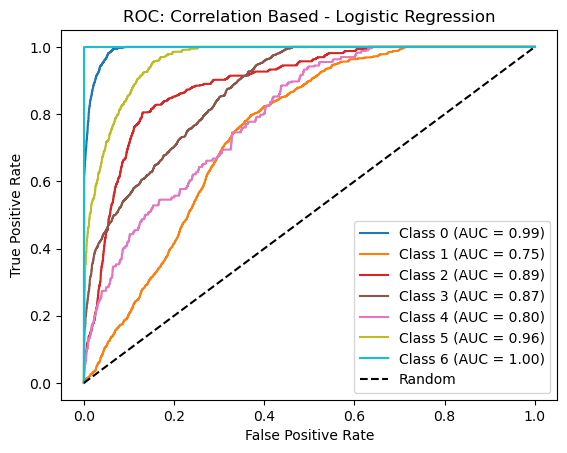

In [20]:
perso_roc(LogReg, X, y)
plt.title('ROC: Correlation Based - Logistic Regression')

### Decision Tree Model

In [21]:
DT = DecisionTreeClassifier(max_depth=2, min_samples_split=30, max_features=2)
DT.fit(X_train ,y_train)

y_pred_DT = DT.predict(X_test)

In [22]:
y_pred_proba_DT = DT.predict_proba(X_test) 
auc_DT = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

Decision Tree AUC: 0.8491958857814961


In [23]:
accuracy_DT, precision_DT, recall_DT, f1_DT = scores(y_test, y_pred_DT)

print(f"Accuracy: {accuracy_DT}")
print(f"Precision: {precision_DT}")
print(f"Recall: {recall_DT}")
print(f"F1 Score: {f1_DT}")

Accuracy: 0.6152398871119473
Precision: 0.4565177731535402
Recall: 0.6152398871119473
F1 Score: 0.5054940100960797


Text(0.5, 1.0, 'ROC: Correlation Based - Decision Tree')

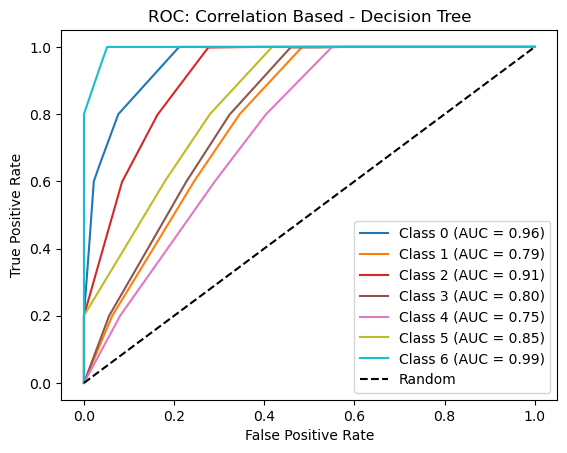

In [24]:
perso_roc(DT, X, y)
plt.title('ROC: Correlation Based - Decision Tree')

### Using KNN model

In [25]:
knn = KNeighborsClassifier(n_neighbors=5000, algorithm='kd_tree')

knn.fit(X_train, y_train)
auc_knn = roc_auc_score(y_test, y_pred_proba_DT, multi_class='ovr')

y_pred_knn = knn.predict(X_test)

In [26]:
accuracy_knn, precision_knn, recall_knn, f1_knn = scores(y_test, y_pred_knn)

print(f"Accuracy: {accuracy_knn}")
print(f"Precision: {precision_knn}")
print(f"Recall: {recall_knn}")
print(f"F1 Score: {f1_knn}")


Accuracy: 0.6891815616180621
Precision: 0.5773781341149749
Recall: 0.6891815616180621
F1 Score: 0.6071202707814015


Text(0.5, 1.0, 'ROC: Correlation Based - K Nearest Neighbour')

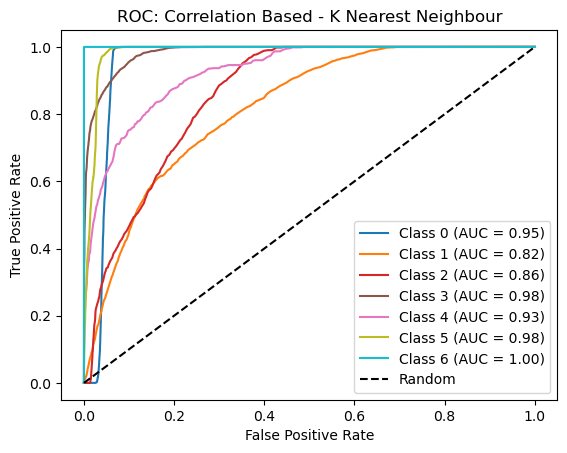

In [27]:
perso_roc(knn, X, y)
plt.title('ROC: Correlation Based - K Nearest Neighbour')

### Scores

In [28]:
model_names = ['RF', 'LogReg', 'KNN', 'DT']
accuracy_scores = [accuracy_RF, accuracy_LogReg, accuracy_knn, accuracy_DT]
precision_scores = [precision_RF, precision_LogReg, precision_knn, precision_DT]
recall_scores = [recall_RF, recall_LogReg, recall_knn, recall_DT]
f1_scores = [f1_RF, f1_LogReg, f1_knn, f1_DT]

metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

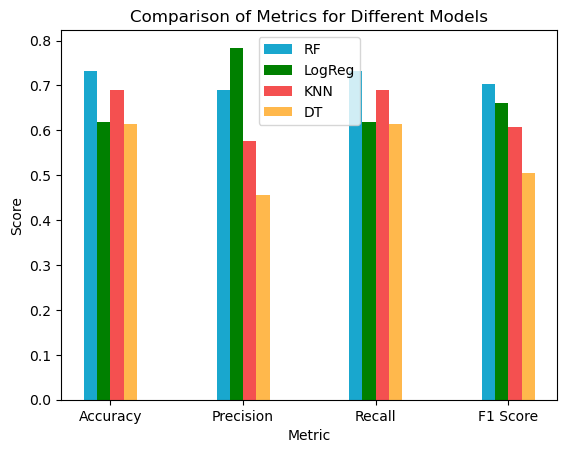

In [54]:
x = np.arange(len(metric_names))

bar_width = 0.1

color_map = {'RF': '#19A7CE', 'LogReg': 'green', 'KNN': '#F45050', 'DT': '#FFB84C'}

fig, ax = plt.subplots()

for i, model_name in enumerate(model_names):
    model_scores = [accuracy_scores[i], precision_scores[i], recall_scores[i], f1_scores[i]]
    bar_positions = x + (i * bar_width)
    ax.bar(bar_positions, model_scores, bar_width, label=model_name, color=color_map[model_name])

ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics for Different Models')
ax.set_xticks(x + (bar_width * 1.5))
ax.set_xticklabels(metric_names)
ax.legend()

In [30]:
models = ['Random Forest', 'Decision Tree', 'Logistic Regression', 'KNN']
auc_values = [auc_RF, auc_DT, auc_LogReg, auc_knn]

Random Forest AUC: 0.8979569026524916
Decision Tree AUC: 0.9362983645274044
Logistic Regression AUC: 0.8933110908352353
KNN AUC: 0.8491958857814961


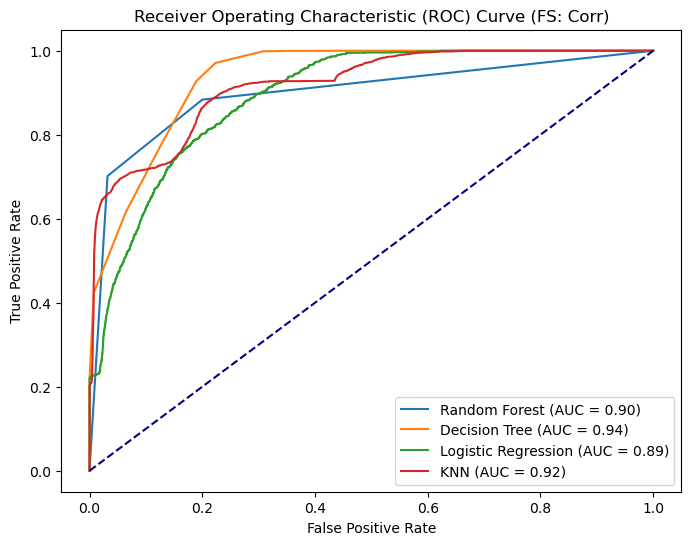

In [31]:
# Random Forest
y_pred_rf = RF.predict_proba(X_test)  # Assuming rf is your trained Random Forest model
fpr_rf, tpr_rf, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_rf.ravel())
auc_rf = auc(fpr_rf, tpr_rf)
print(f"Random Forest AUC: {auc_rf}")

# Decision Tree
y_pred_dt = DT.predict_proba(X_test)  # Assuming dt is your trained Decision Tree model
fpr_dt, tpr_dt, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_dt.ravel())
auc_dt = auc(fpr_dt, tpr_dt)
print(f"Decision Tree AUC: {auc_dt}")

# Logistic Regression
y_pred_lr = LogReg.predict_proba(X_test)  # Assuming lr is your trained Logistic Regression model
fpr_lr, tpr_lr, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), y_pred_lr.ravel())
auc_lr = auc(fpr_lr, tpr_lr)
print(f"Logistic Regression AUC: {auc_lr}")

# SVC
decision_scores_svc = knn.predict_proba(X_test)
fpr_knn, tpr_knn, _ = roc_curve(label_binarize(y_test, classes=np.unique(y_test)).ravel(), decision_scores_svc.ravel())
auc_svc = auc(fpr_knn, tpr_knn)
print(f"KNN AUC: {auc_knn}")

# Plotting the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})")
plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.2f})")
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.2f})")
plt.plot(fpr_knn, tpr_knn, label=f"KNN (AUC = {auc_svc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (FS: Corr)')
plt.legend(loc='lower right')
